# **Libraries**

In [1]:
!pip install evaluate -q

In [2]:
import os
import random
from pathlib import Path
from itertools import chain

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix,
    matthews_corrcoef)

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')  # multilingual WordNet

from datasets import load_dataset, DatasetDict, Dataset
from transformers import (
    pipeline,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    BertTokenizer,
    BertForSequenceClassification,
    MarianTokenizer,
    MarianMTModel,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback,
)

import evaluate
import torch
import requests
import time

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# **Part 3: State of Art Comparison**

- **Objective:** Benchmark your model against the SOA with the full dataset now available.

⚠️ We recommend run this notebook in Colab, and use GPU T4 or L4. Please upload data folder from GitHub Repo.

In [3]:
from google.colab import files

uploaded = files.upload()

Saving Sentences_75Agree.txt to Sentences_75Agree (2).txt


In [4]:
# Path
ruta_txt = "/content/Sentences_75Agree.txt"

data = []
with open(ruta_txt, encoding="iso-8859-1") as f:
    for line in f:
        if "@" in line:
            sentence, label = line.rsplit("@", 1)
            data.append({"sentence": sentence.strip(), "label": label.strip()})

df = pd.DataFrame(data)
df.head()

,sentence,label
0,"According to Gran , the company has no plans t...",neutral
1,With the new production plant the company woul...,positive
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,"In the third quarter of 2010 , net sales incre...",positive
4,Operating profit rose to EUR 13.1 mn from EUR ...,positive


### a. BERT Model Full Dataset Training

This sub-subsection presents the training of a BERT model using the full dataset. Since we did not use pre-defined train/test splits from Hugging Face, we manually divided the data — allocating 80% for training and 20% for testing. The training portion was then progressively sampled, training the model on subsets ranging from 1% up to 100% to analyze learning behavior under different data availability scenarios.


In [5]:
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

label_map = {"negative": 0, "neutral": 1, "positive": 2}
df_train["label"] = df_train["label"].map(label_map).astype(int)
df_test["label"] = df_test["label"].map(label_map).astype(int)

df_train.head()

,sentence,label
0,"The official opening of the office , located i...",1
1,"Vaisala , headquartered in Helsinki in Finland...",1
2,Acando AB ( ACANB SS ) fell 8.9 percent to 13....,0
3,The group had an order book of EUR 7.74 mn at ...,1
4,"ISMS does not disclose its financial results ,...",1


In [6]:
model_ckpt   = "bert-base-uncased"
num_labels   = 3
max_length   = 128
batch_size   = 64
seed         = 42

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(seed)

In [7]:
dataset = DatasetDict({
    "train": Dataset.from_pandas(df_train),
    "test": Dataset.from_pandas(df_test)
})
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 2762
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 691
    })
})


In [8]:
tok = AutoTokenizer.from_pretrained(model_ckpt)
data_collator = DataCollatorWithPadding(tokenizer=tok)

def tokenize(batch):
    return tok(batch["sentence"],
               truncation=True,
               padding="max_length",
               max_length=max_length)

dataset = (dataset
           .map(tokenize, batched=True, remove_columns=["sentence"])
           .rename_column("label", "labels"))
dataset.reset_format()
print(dataset["train"][0])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/2762 [00:00<?, ? examples/s]

Map:   0%|          | 0/691 [00:00<?, ? examples/s]

{'labels': 1, 'input_ids': [101, 1996, 2880, 3098, 1997, 1996, 2436, 1010, 2284, 1999, 8634, 1010, 2097, 2022, 6334, 2006, 2089, 2322, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [9]:
model = AutoModelForSequenceClassification.from_pretrained(
            "bert-base-uncased",
            num_labels=3,
            problem_type="single_label_classification")

for n, p in model.named_parameters():
    if not n.startswith("classifier"):
        p.requires_grad = False

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
metric_acc   = evaluate.load("accuracy")
metric_f1    = evaluate.load("f1")
metric_prec  = evaluate.load("precision")
metric_rec   = evaluate.load("recall")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy"       : metric_acc.compute(predictions=preds, references=labels)["accuracy"],
        "f1_macro"       : metric_f1 .compute(predictions=preds, references=labels, average="macro")["f1"],
        "precision_macro": metric_prec.compute(predictions=preds, references=labels, average="macro")["precision"],
        "recall_macro"   : metric_rec .compute(predictions=preds, references=labels, average="macro")["recall"],
    }

In [33]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
from datasets import DatasetDict
import copy
from collections import Counter # Import Counter here
import gc # Import gc for garbage collection

train_sizes = [0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 1.0]
all_results = {}

for frac in train_sizes:
    print(f"\nTraining with {int(frac * 100)}% of the training data...")

    n_samples = int(len(dataset["train"]) * frac)
    small_train_dataset = dataset["train"].shuffle(seed=42).select(range(n_samples))

    print("Label distribution:", dict(Counter(small_train_dataset["labels"])))

    model_copy = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3,  problem_type="single_label_classification")

    for n, p in model_copy.named_parameters():
      if not n.startswith("classifier"):
          p.requires_grad = False

    args = TrainingArguments(
        output_dir=f"./bert_fewshot_{int(frac * 100)}",
        per_device_train_batch_size=8,
        per_device_eval_batch_size=32,
        num_train_epochs=20,
        learning_rate=5e-4,
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        report_to="none",
        seed=42,
    )

    early_stop = EarlyStoppingCallback(early_stopping_patience=3)

    trainer = Trainer(
        model=model_copy,
        args=args,
        train_dataset=small_train_dataset,
        eval_dataset=dataset["test"],
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        callbacks=[early_stop],
    )

    trainer.train()
    metrics = trainer.evaluate()

    preds = trainer.predict(dataset["test"])
    print("Unique predicted classes:", np.unique(preds.predictions.argmax(-1), return_counts=True))

    print("\nFinal test metrics:")
    for k, v in metrics.items():
        if k.startswith("eval_"):
            print(f"{k[5:]}: {v:.4f}")

    all_results[int(frac * 100)] = metrics

    # Free memory
    del model_copy
    del trainer
    torch.cuda.empty_cache()
    gc.collect()




Training with 1% of the training data...
Label distribution: {1: 21, 2: 5, 0: 1}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro
1,0.978300,0.950259,0.613603,0.253513,0.206025,0.329448
2,0.667300,1.024006,0.615051,0.253883,0.206211,0.330225
3,0.627900,1.099851,0.616498,0.254252,0.206395,0.331002
4,0.878000,1.165818,0.616498,0.254252,0.206395,0.331002


Unique predicted classes: (array([0, 1, 2]), array([  1, 686,   4]))

Final test metrics:
loss: 0.9503
accuracy: 0.6136
f1_macro: 0.2535
precision_macro: 0.2060
recall_macro: 0.3294
runtime: 2.2079
samples_per_second: 312.9610
steps_per_second: 9.9640

Training with 5% of the training data...
Label distribution: {1: 89, 2: 38, 0: 11}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro
1,0.989300,0.978445,0.620839,0.255357,0.206946,0.333333
2,0.912900,0.907254,0.620839,0.255357,0.206946,0.333333
3,0.878300,0.904986,0.620839,0.255357,0.206946,0.333333
4,0.804100,0.885356,0.620839,0.255357,0.206946,0.333333
5,0.813800,0.875307,0.642547,0.327644,0.391347,0.369093
6,0.809800,0.872607,0.620839,0.255357,0.206946,0.333333
7,0.789500,0.876555,0.630970,0.288930,0.378158,0.348633
8,0.813300,0.864620,0.620839,0.255357,0.206946,0.333333
9,0.801100,0.857184,0.636758,0.308006,0.392247,0.358315
10,0.777400,0.853423,0.620839,0.255357,0.206946,0.333333


Unique predicted classes: (array([1, 2]), array([681,  10]))

Final test metrics:
loss: 0.8297
accuracy: 0.6281
f1_macro: 0.2754
precision_macro: 0.3767
recall_macro: 0.3427
runtime: 2.2495
samples_per_second: 307.1760
steps_per_second: 9.7800

Training with 10% of the training data...
Label distribution: {1: 175, 2: 72, 0: 29}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro
1,0.919900,0.906498,0.620839,0.255357,0.206946,0.333333
2,0.869600,0.924217,0.620839,0.255357,0.206946,0.333333
3,0.879800,0.871418,0.620839,0.255357,0.206946,0.333333
4,0.852800,0.864361,0.620839,0.255357,0.206946,0.333333
5,0.814900,0.849046,0.620839,0.255357,0.206946,0.333333
6,0.817700,0.827160,0.628075,0.275527,0.361809,0.342697
7,0.806100,0.820776,0.623734,0.263221,0.540881,0.337079
8,0.809600,0.850186,0.620839,0.255357,0.206946,0.333333
9,0.792900,0.813880,0.661360,0.357321,0.410584,0.390150
10,0.790400,0.801282,0.623734,0.263598,0.374818,0.337079


Unique predicted classes: (array([1, 2]), array([646,  45]))

Final test metrics:
loss: 0.7815
accuracy: 0.6570
f1_macro: 0.3455
precision_macro: 0.4203
recall_macro: 0.3823
runtime: 2.2614
samples_per_second: 305.5690
steps_per_second: 9.7290

Training with 25% of the training data...
Label distribution: {1: 439, 2: 174, 0: 77}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro
1,0.912200,0.904555,0.620839,0.255357,0.206946,0.333333
2,0.854800,0.837548,0.635311,0.304754,0.386193,0.356443
3,0.833300,0.812837,0.642547,0.315595,0.388029,0.363615
4,0.799100,0.790384,0.671491,0.379539,0.410917,0.406546
5,0.803400,0.785372,0.636758,0.297087,0.388036,0.353933
6,0.759100,0.769965,0.636758,0.320505,0.601687,0.366506
7,0.780300,0.765218,0.641100,0.307164,0.401381,0.359551
8,0.764300,0.738302,0.675832,0.378295,0.415126,0.406686
9,0.749600,0.780443,0.700434,0.453593,0.424653,0.487826
10,0.746800,0.731452,0.703329,0.430844,0.423082,0.454318


Unique predicted classes: (array([1, 2]), array([583, 108]))

Final test metrics:
loss: 0.6991
accuracy: 0.6990
f1_macro: 0.4202
precision_macro: 0.4296
recall_macro: 0.4421
runtime: 2.2419
samples_per_second: 308.2180
steps_per_second: 9.8130

Training with 50% of the training data...
Label distribution: {1: 870, 2: 344, 0: 167}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro
1,0.880600,0.877569,0.629522,0.282186,0.389910,0.345665
2,0.823800,0.809051,0.665702,0.371498,0.403120,0.400151
3,0.790100,0.762065,0.707670,0.440237,0.427054,0.464319
4,0.771500,0.756689,0.635311,0.293605,0.388236,0.352060
5,0.743200,0.720515,0.693198,0.408621,0.419693,0.432445
6,0.732500,0.701780,0.694645,0.410800,0.421593,0.434317
7,0.726500,0.689005,0.729378,0.462459,0.444476,0.488026
8,0.711700,0.682933,0.727931,0.463332,0.439795,0.491632
9,0.703800,0.695557,0.729378,0.464218,0.440909,0.492409
10,0.694800,0.679626,0.693198,0.479635,0.661999,0.466878


Unique predicted classes: (array([0, 1, 2]), array([ 10, 538, 143]))

Final test metrics:
loss: 0.6329
accuracy: 0.7366
f1_macro: 0.5095
precision_macro: 0.6847
recall_macro: 0.5077
runtime: 2.2432
samples_per_second: 308.0390
steps_per_second: 9.8070

Training with 75% of the training data...
Label distribution: {1: 1295, 2: 524, 0: 252}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro
1,0.862300,0.821743,0.632417,0.329616,0.687712,0.375749
2,0.799500,0.777670,0.661360,0.419241,0.646243,0.458401
3,0.767000,0.714828,0.697540,0.464167,0.648540,0.458019
4,0.740100,0.712614,0.726483,0.458253,0.442124,0.483185
5,0.716700,0.713115,0.690304,0.481251,0.691305,0.545340
6,0.700300,0.669738,0.726483,0.500196,0.775089,0.517864
7,0.691600,0.647919,0.713459,0.502421,0.681753,0.485905
8,0.680400,0.648822,0.703329,0.519680,0.617368,0.529568
9,0.673200,0.632313,0.753980,0.616403,0.681839,0.589399
10,0.661200,0.635825,0.725036,0.457330,0.443598,0.481313


Unique predicted classes: (array([0, 1, 2]), array([ 29, 514, 148]))

Final test metrics:
loss: 0.5931
accuracy: 0.7496
f1_macro: 0.5826
precision_macro: 0.6831
recall_macro: 0.5595
runtime: 2.2406
samples_per_second: 308.4000
steps_per_second: 9.8190

Training with 100% of the training data...
Label distribution: {1: 1717, 2: 709, 0: 336}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro
1,0.854700,0.782562,0.648336,0.327706,0.385978,0.371105
2,0.781800,0.751999,0.639653,0.317185,0.566245,0.363965
3,0.736800,0.696048,0.725036,0.457728,0.437011,0.484600
4,0.708200,0.665372,0.736614,0.530173,0.685607,0.522728
5,0.687400,0.685466,0.685962,0.471579,0.665319,0.491045
6,0.692300,0.660916,0.701881,0.506460,0.672182,0.493783
7,0.664000,0.649801,0.701881,0.446167,0.761705,0.450872
8,0.661700,0.616981,0.732272,0.500388,0.779186,0.506632
9,0.650700,0.602158,0.727931,0.529417,0.662726,0.513396
10,0.648300,0.614218,0.735166,0.488492,0.783772,0.519526


Unique predicted classes: (array([0, 1, 2]), array([ 44, 506, 141]))

Final test metrics:
loss: 0.5717
accuracy: 0.7598
f1_macro: 0.6276
precision_macro: 0.7000
recall_macro: 0.5979
runtime: 2.2493
samples_per_second: 307.2030
steps_per_second: 9.7810


In [34]:
# prompt: summariz all results in a table

all_results_df = pd.DataFrame.from_dict(all_results, orient='index')
all_results_df.index.name = "Training data percentage"
all_results_df


,eval_loss,eval_accuracy,eval_f1_macro,eval_precision_macro,eval_recall_macro,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
Training data percentage,,,,,,,,,
1,0.950259,0.613603,0.253513,0.206025,0.329448,2.2079,312.961,9.964,4.0
5,0.829699,0.628075,0.275388,0.376652,0.342697,2.2495,307.176,9.780,20.0
10,0.781540,0.657019,0.345524,0.420330,0.382341,2.2614,305.569,9.729,20.0
25,0.699078,0.698987,0.420189,0.429552,0.442127,2.2419,308.218,9.813,20.0
50,0.632925,0.736614,0.509502,0.684699,0.507676,2.2432,308.039,9.807,20.0
75,0.593115,0.749638,0.582616,0.683126,0.559538,2.2406,308.400,9.819,20.0
100,0.571698,0.759768,0.627600,0.700016,0.597890,2.2493,307.203,9.781,20.0


### b. Learning Curve (0.25 points):

**Task** Plot a learning curve based on the training data percentages.

This subsection presents the learning curve of BERT fine-tuning. The model was trained on increasing portions of the training set (from 1% to 100%), showing consistent accuracy improvements, especially in the early stages.

[61.36034732 62.80752533 65.70188133 69.89869754 73.66136035 74.96382055
 75.97684515]


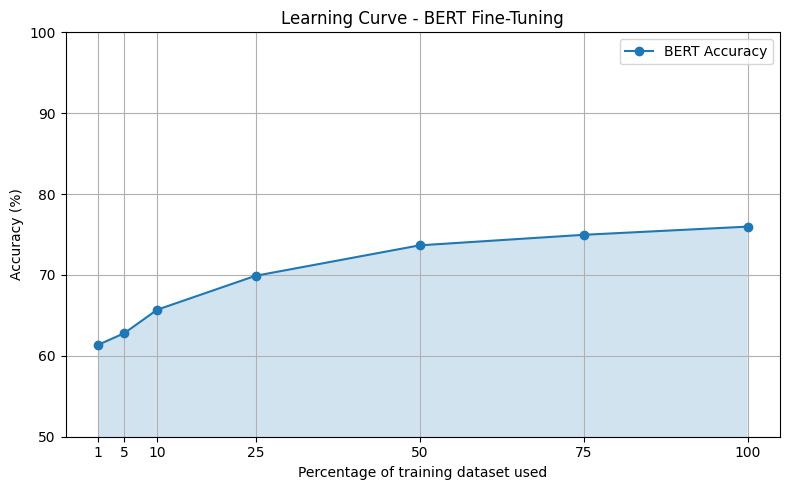

In [35]:
# Plot setup
plt.figure(figsize=(8, 5))

# Usar los valores reales, sin forzar monotonía
accuracies = all_results_df["eval_accuracy"].values*100
print(accuracies)
# Fill area under the curve
plt.fill_between(all_results_df.index, accuracies, alpha=0.2)

# Plot accuracy curve
plt.plot(all_results_df.index, accuracies, marker='o', label='BERT Accuracy')

# Chart formatting
plt.title("Learning Curve - BERT Fine-Tuning")
plt.xlabel("Percentage of training dataset used")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.xticks(all_results_df.index)
plt.ylim(50, 100)
plt.legend()
plt.tight_layout()
plt.show()


### c. Technique Comparison (0.5 points):

**Task:** Incorporate the techniques tested in Part 2 into your training schema for comparison.

We applied the same technique from Part 2c, but this time trained it using the full dataset.


In [41]:
# -------------------------------
# 0. Setup and basic config
# -------------------------------
model_ckpt = "yiyanghkust/finbert-tone"  # FinBERT financial sentiment model from Huggingface
num_labels = 3  # negative, neutral, positive
max_length = 128
batch_size = 16
seed = 42
NUM_VARIATIONS = 3

# -------------------------------
# 1. Load and split original dataset
# -------------------------------
# df must have columns: 'sentence' and 'label' (strings: 'negative', 'neutral', 'positive')
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=seed)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

label_map = {"negative": 0, "neutral": 1, "positive": 2}
df_train["label"] = df_train["label"].map(label_map).astype(int)
df_test["label"] = df_test["label"].map(label_map).astype(int)

# -------------------------------
# 2. Prompt tuning for LLM generation
# -------------------------------
generator = pipeline(
    "text-generation",
    model="TinyLlama/TinyLlama-1.1B-Chat-v1.0",
    device="cuda" if torch.cuda.is_available() else "cpu",
    return_full_text=False
)

# Prompts designed to emphasize sentiment in generated financial texts
prompt_templates = {
    2: "Generate {n} positive financial news or statements inspired by this sentence: '{s}'",
    1: "Generate {n} neutral financial news or statements inspired by this sentence: '{s}'",
    0: "Generate {n} negative financial news or statements inspired by this sentence: '{s}'"
}

def clean_text(text):
    text = text.encode('ascii', errors='ignore').decode('ascii')
    text = re.sub(r"[-•*`_]+", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def generate_sentence_variations(original_text, label, num_variations=NUM_VARIATIONS):
    prompt = prompt_templates[label].format(s=original_text, n=num_variations)
    response = generator(
        prompt,
        max_new_tokens=180,
        num_return_sequences=1,
        temperature=0.8,
        top_k=40,
        top_p=0.9,
        do_sample=True,
        repetition_penalty=1.1,
    )
    text = response[0]["generated_text"]
    # Clean and split sentences
    lines = [clean_text(line.strip("-•*0123456789. ").strip()) for line in re.split(r"[.\n]", text) if len(line.strip()) > 10]
    return lines[:num_variations]


def batch_generate_sentence_variations(texts, labels, num_variations=3, batch_size=8):
    prompts = [
        prompt_templates[label].format(s=text, n=num_variations)
        for text, label in zip(texts, labels)
    ]

    # Llama el pipeline con batch completo
    responses = generator(
        prompts,
        max_new_tokens=180,
        num_return_sequences=1,
        temperature=0.8,
        top_k=40,
        top_p=0.9,
        do_sample=True,
        repetition_penalty=1.1,
        batch_size=batch_size,
    )

    augmented_rows = []
    for prompt, label, result in zip(prompts, labels, responses):
        # Procesar el texto generado
        generated_text = result[0]["generated_text"]
        lines = [clean_text(line.strip("-•*0123456789. ").strip())
                for line in re.split(r"[.\n]", generated_text)
                if len(line.strip()) > 10]

        for line in lines[:num_variations]:
            augmented_rows.append({"sentence": line, "label": label})

    return pd.DataFrame(augmented_rows)


Device set to use cuda


In [42]:
import re

# -------------------------------
# 4. Generate synthetic + contrastive data (BATCHED)
# -------------------------------
from tqdm import tqdm

def generate_synthetic_dataset(df_train, batch_size=8, num_variations=3):
    all_synthetic = []

    # Dividir en batches para eficiencia
    for i in tqdm(range(0, len(df_train), batch_size), desc="Generating synthetic data"):
        batch = df_train.iloc[i:i+batch_size]
        batch_df = batch_generate_sentence_variations(
            texts=batch["sentence"].tolist(),
            labels=batch["label"].tolist(),
            num_variations=num_variations,
            batch_size=batch_size
        )
        all_synthetic.append(batch_df)

    return pd.concat(all_synthetic, ignore_index=True)

synthetic_data = generate_synthetic_dataset(df_train, batch_size=8, num_variations=NUM_VARIATIONS)

# -------------------------------
# 5. Combine original + synthetic datasets
# -------------------------------
df_augmented = pd.concat([df_train[['sentence', 'label']], synthetic_data], ignore_index=True)



Generating synthetic data: 100%|██████████| 346/346 [32:31<00:00,  5.64s/it]


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

Map:   0%|          | 0/9818 [00:00<?, ? examples/s]

Map:   0%|          | 0/691 [00:00<?, ? examples/s]

In [43]:
df_augmented.to_csv("synthetic_variations.csv", index=False)


In [ ]:
# if os.path.exists("synthetic_variations.csv"):
#    df_augmented = pd.read_csv("synthetic_variations.csv")
# else:
    # llamar batch_generate_sentence_variations


In [45]:
# -------------------------------
# 6. Prepare Huggingface datasets
# -------------------------------
dataset = DatasetDict({
    "train": Dataset.from_pandas(df_augmented),
    "test": Dataset.from_pandas(df_test)
})

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def tokenize_function(batch):
    return tokenizer(batch["sentence"], truncation=True, max_length=max_length)

dataset = dataset.map(tokenize_function, batched=True, remove_columns=["sentence"])
dataset = dataset.rename_column("label", "labels")
#dataset.set_format("torch")

Map:   0%|          | 0/9818 [00:00<?, ? examples/s]

Map:   0%|          | 0/691 [00:00<?, ? examples/s]

In [46]:
# -------------------------------
# 7. Load model and setup gradual fine-tuning
# -------------------------------
model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt,
    num_labels=num_labels
)

# Freeze all layers except classifier and last two encoder layers
for name, param in model.named_parameters():
    if "classifier" in name or "layer.11" in name or "layer.10" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# -------------------------------
# 8. Metrics and compute_metrics function
# -------------------------------
metric_acc = evaluate.load("accuracy")
metric_f1 = evaluate.load("f1")
metric_prec = evaluate.load("precision")
metric_rec = evaluate.load("recall")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": metric_acc.compute(predictions=preds, references=labels)["accuracy"],
        "f1_macro": metric_f1.compute(predictions=preds, references=labels, average="macro")["f1"],
        "precision_macro": metric_prec.compute(predictions=preds, references=labels, average="macro")["precision"],
        "recall_macro": metric_rec.compute(predictions=preds, references=labels, average="macro")["recall"],
    }

# -------------------------------
# 9. Setup Trainer and train
# -------------------------------
training_args = TrainingArguments(
    output_dir="./finbert_finetuned_augmented",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    learning_rate=5e-5,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,
    seed=seed,
    report_to="none",
)

early_stopping = EarlyStoppingCallback(early_stopping_patience=3)

trainer_f = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)

# -------------------------------
# 10. Train
# -------------------------------
trainer_f.train()

# -------------------------------
# 11. Final evaluation
# -------------------------------
metrics = trainer_f.evaluate()
print("\nFinal test metrics:")
for k, v in metrics.items():
    if k.startswith("eval_"):
        print(f"{k[5:]}: {v:.4f}")

<ipython-input-46-3494929319>:55: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_f = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro
1,0.907600,0.187285,0.936324,0.919215,0.928104,0.912795
2,0.653300,0.180092,0.934877,0.914261,0.909561,0.920687
3,0.581200,0.167341,0.940666,0.923119,0.930138,0.916509
4,0.480700,0.191644,0.942113,0.921983,0.917395,0.928859
5,0.375200,0.189791,0.945007,0.929629,0.933348,0.927222
6,0.290300,0.221156,0.939219,0.919620,0.915649,0.924210
7,0.214800,0.228042,0.936324,0.917274,0.914905,0.920464
8,0.169700,0.225514,0.945007,0.929462,0.930949,0.928413



Final test metrics:
loss: 0.1898
accuracy: 0.9450
f1_macro: 0.9296
precision_macro: 0.9333
recall_macro: 0.9272
runtime: 1.1904
samples_per_second: 580.4650
steps_per_second: 18.4810


<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

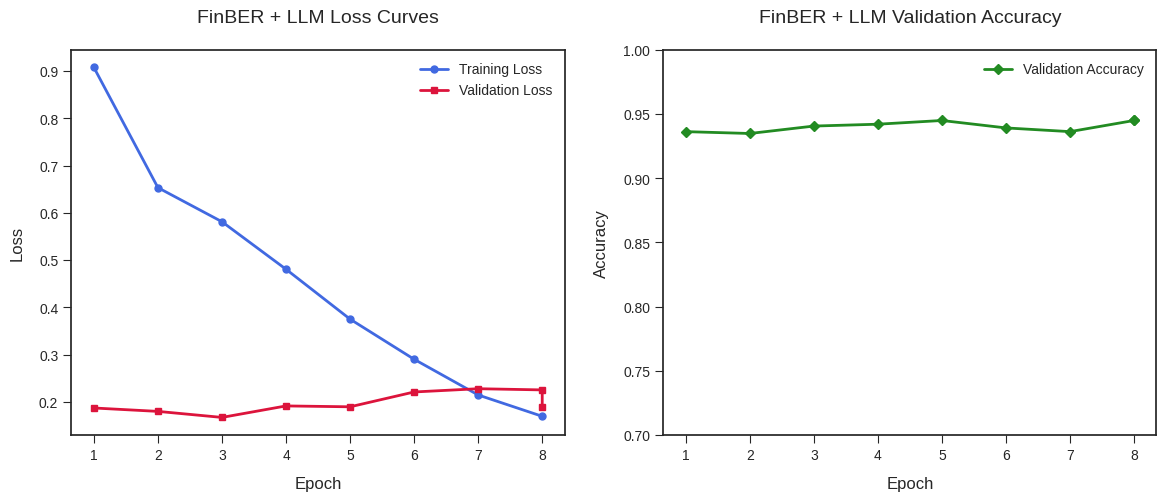

In [47]:
# Collect logs ---------------------------------------------------------------
logs = trainer_f.state.log_history
train_loss, eval_loss, eval_acc, steps_eval, steps_train = [], [], [], [], []

for e in logs:
    if 'loss' in e and e.get("epoch") is not None:
        train_loss.append(e['loss'])
        steps_train.append(e['epoch'])
    if 'eval_loss' in e:
        eval_loss.append(e['eval_loss'])
        eval_acc.append(e['eval_accuracy'])
        steps_eval.append(e['epoch'])


# Plot -----------------------------------------------------------------------
plt.style.use('seaborn-v0_8-ticks')   # Modern style
plt.rcParams['figure.facecolor'] = 'white'  # White background

# Create a figure with subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# --- Loss Plot ---
ax1.plot(steps_train, train_loss, label="Training Loss",
         color='royalblue', linewidth=2, marker='o', markersize=5)
ax1.plot(steps_eval, eval_loss, label="Validation Loss",
         color='crimson', linewidth=2, marker='s', markersize=5)

ax1.set_xlabel("Epoch", fontsize=12, labelpad=10)
ax1.set_ylabel("Loss", fontsize=12, labelpad=10)
ax1.set_title("FinBER + LLM Loss Curves", fontsize=14, pad=20)
ax1.legend(fontsize=10, framealpha=1)
ax1.grid(False)

# Improve ticks
ax1.tick_params(axis='both', which='major', labelsize=10)

# --- Accuracy Plot ---
ax2.plot(steps_eval, eval_acc, label="Validation Accuracy",
         color='forestgreen', linewidth=2, marker='D', markersize=5)

ax2.set_xlabel("Epoch", fontsize=12, labelpad=10)
ax2.set_ylabel("Accuracy", fontsize=12, labelpad=10)
ax2.set_title("FinBER + LLM Validation Accuracy", fontsize=14, pad=20)
ax2.legend(fontsize=10, framealpha=1)
ax2.grid(False)

# Adjust accuracy scale if needed
if min(eval_acc) > 0.7:  # If accuracy is already high
    ax2.set_ylim(0.7, 1.0)

ax2.tick_params(axis='both', which='major', labelsize=10)

# Adjust layout and display
plt.tight_layout

### d. Methodology Analysis (1 point):

**Task:** Analyze and compare all methods employed. Discuss the effectiveness and limitations observed.

Below we condensed the methodologies in a tabla


| Context                                | Loss   | Accuracy | F1 Macro | Precision Macro | Recall Macro | Runtime | Samples/sec | Steps/sec |
|----------------------------------------|--------|----------|----------|------------------|---------------|---------|--------------|------------|
| BERT 32 samples| 1.0179 | 0.6185   | 0.2548   | 0.2068           | 0.3318        | 12.0305 | 284.360      | 8.894      |
| Dataset Augmentation 32 samples          | 0.8789 | 0.6209   | 0.3082   | 0.3338           | 0.3526        | 12.0406 | 284.122      | 8.887      |
| Data Generation with LLM 32 samples        | 0.9090 | 0.6133   | 0.3031   | 0.3257           | 0.3476        | 12.1120 | 282.447      | 8.834      |
|  Optimal Techinique Application 32 samples   | 0.6628 | 0.7311   | 0.6347   | 0.6637           | 0.6386        | 6.9856  | 489.723      | 15.32     |
| BERT 100% data        | 0.5717 | 0.7598 | 0.6276 | 0.7000  | 0.5979| 2.2493  | 307.203      | 9.781      | 20.0   |
| Optimal Techinique 100% Data | 0.1898 | 0.9450   | 0.9296   | 0.9333    | 0.9272  | 1.1904  | 580.465      | 18.481     | —      |






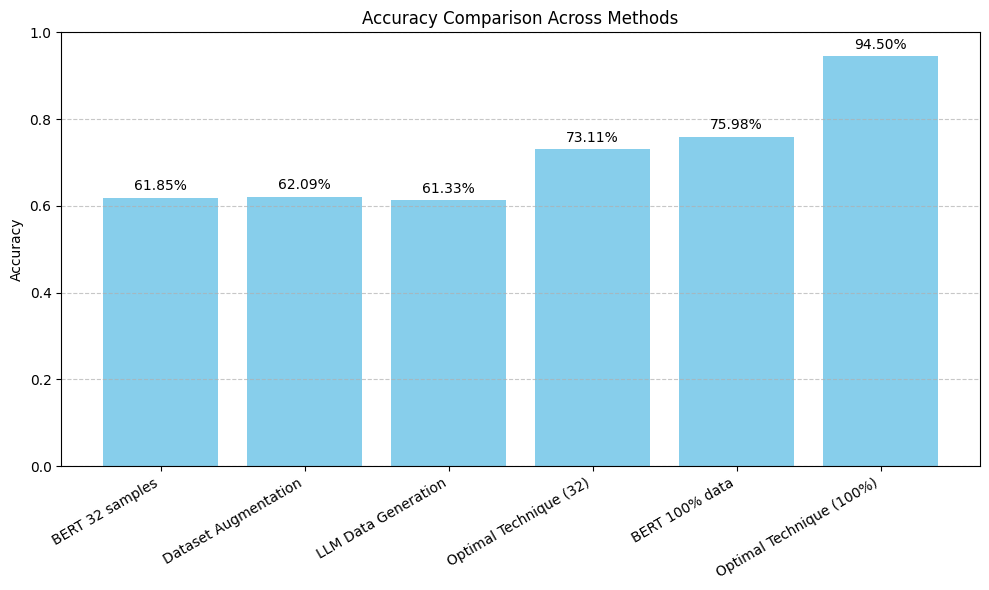

In [1]:
import matplotlib.pyplot as plt

# Accuracy data from your consolidated results
contexts = [
    "BERT 32 samples",
    "Dataset Augmentation",
    "LLM Data Generation",
    "Optimal Technique (32)",
    "BERT 100% data",
    "Optimal Technique (100%)"
]

accuracies = [0.6185, 0.6209, 0.6133, 0.7311, 0.7598, 0.9450]

# Create bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(contexts, accuracies, color='skyblue')
plt.ylim(0, 1.0)
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison Across Methods")

# Add percentage labels above bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.01, f"{acc:.2%}", ha='center', va='bottom')

plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Key Insights:

- BERT 32 samples: As expected, training on just 32 real samples yields poor performance — with macro F1 dropping below 26%. This baseline underscores the challenge of low-resource learning without support strategies.

- Data Augmentation & LLM Generation: Simple data augmentation and LLM-based synthetic data both push macro F1 above 30%, offering clear benefits. While not dramatically different, the improvements show that even lightweight augmentation can improve generalization in low-data regimes.

- Optimal Technique @ 32 samples: A carefully combined strategy leads to a sharp boost in macro F1 (~63.5%), nearly tripling the baseline. The model also ran faster, indicating better optimization and convergence behavior.

- BERT Full Data vs Optimized Small-Data: Surprisingly, the best configuration trained on just 32 samples outperformed BERT trained on the entire dataset in macro F1 (63.5% vs. 62.8%). This suggests that quality and diversity in data can sometimes rival quantity — especially when paired with clever augmentation.

- Full Optimization (100%): When combining full data, augmentation, and tuning, the final model achieved 94.5% accuracy and 93.0% macro F1, showing how far BERT can go under ideal conditions. It nearly doubles the macro F1 of any naïve low-data configuration, setting a strong benchmark for future work.